In [1]:
# if "preprocessing" folder in current folders -> cd back to original folder
%cd /content
import os
if os.path.exists("bsc-thesis"):
  # if bsc-thesis folder already exists; completely remove
  !rm -rf bsc-thesis

# this makes sure cached files are readily available (for calling e.g. `gather_data_cached`)
!apt-get install git-lfs
!git lfs install

# cloning repo
branch = "main"
!git clone --branch $branch https://github.com/maviddoerdijk/bsc-thesis.git

# moving into project dir
%cd bsc-thesis/src
%ls

/content
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Git LFS initialized.
Cloning into 'bsc-thesis'...
remote: Enumerating objects: 533, done.
remote: Counting objects: 100% (277/277), done.
remote: Compressing objects: 100% (215/215), done.
remote: Total 533 (delta 128), reused 168 (delta 53), pack-reused 256 (from 1)
Receiving objects: 100% (533/533), 23.32 MiB | 15.20 MiB/s, done.
Resolving deltas: 100% (275/275), done.
Filtering content: 100% (14/14), 1.75 GiB | 153.09 MiB/s, done.
/content/bsc-thesis/src
backtesting/  data/      main.ipynb  models/         utils/
config/       external/  main.py     preprocessing/


In [2]:
!pip install ta
!pip install pykalman
!pip install PyWavelets
!pip install curl-cffi

## specific packages for time moe
!pip install accelerate==0.28.0 # standard google colab version is 1.6.0 (apr 1, 2025), but for stability, we use time moe's 0.28.0 (mar 12, 2024)
!pip install transformers==4.40.1 # standard google colab version is 4.51.3, but time moe repo requirements mention/prefer 4.40.1 for stability
!pip install datasets==2.18.0
FLASH_ATTN = False # set to true if using this
if FLASH_ATTN:
  !pip install flash-attn==2.6.3 # optional but recommended by the repo

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=f65fb983e8a6b9a4514f263df0cb14f6773eadcccc90175b7ded2db1fc24315c
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 131.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [16]:
# Module imports
import pandas as pd
import numpy as np
from typing import Optional, Callable, Dict, Any
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm.auto import tqdm # note: using tqdm.auto usually automatically chooses the right import based on whether you're in CLI, notebook or somewhere else
import torch.nn as nn
import itertools
from pykalman import KalmanFilter
import ast
import re
from tabulate import tabulate
from datetime import datetime

# Custom Imports
from models.statistical_models import create_dataset, default_normalize, rmse_metric, acc_metric, kalman_filter_average, kalman_filter_regression, kalman_filter_regression_multivariate
from preprocessing.cointegration import find_cointegrated_pairs
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.technical_indicators import combine_pairs_data
from preprocessing.wavelet_denoising import wav_den
from preprocessing.filters import step_1_filter_remove_nans, step_2_filter_liquidity
from backtesting.trading_strategy import trade
from backtesting.utils import calculate_return_uncertainty
from utils.visualization import plot_return_uncertainty, plot_comparison

## workflow imports
from models.statistical_models import execute_kalman_workflow
from models.transformer_model import execute_transformer_workflow

## specific caching imports (should be changed in case you want to gather data live)
from data.scraper import load_cached_etf_tickers
from data.data_collection_cache import gather_data_cached, _get_filename

# Any other changes to be made throughout the entire notebook
plt.style.use('seaborn-v0_8')

# All timeperiods:
```
# startDateStr = '2010-10-01'
# endDateStr = '2024-10-02'
# startDateStr = '2008-10-01'
# endDateStr = '2018-10-02'
# startDateStr = '2007-01-01'
# endDateStr = '2021-12-31'
# startDateStr = '2007-01-01'
# endDateStr = '2024-12-31'
# startDateStr = '2007-01-01'
# endDateStr = '2016-12-31'
# startDateStr = '2007-01-01'
# endDateStr = '2021-12-31'
```

## 1. Data gathering and filtering

In [4]:
# Step 1: Gather cached data and filter pairs based on cointegration and such
# NOTE: all the functions used here are explained in much more detail in src/main.ipynb, but this notebook is simply focused on finding how to ge the Transformer model to work as I wish.
startDateStr = '2008-10-01'
endDateStr = '2018-10-02' # documentation said that endDateStr is exclusive for both yahoofinance and the original code, but actually printing the shapes showed otherwise..
instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
pairs_data = {key:value[1]  for (key, value) in pairs.items()}
pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
# Extract the most highly cointegrated pairs
ticker_a, ticker_b = pairs_data_filtered[0][0][0], pairs_data_filtered[0][0][1]
pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
# Note about pairs_timeseries_df: the timeseries output on which we should train are found in the key "Spread_Close"
# But, also the input features are the following keys: ['S1_rsi', 'S2_rsi', 'S1_mfi', 'S2_mfi', 'S1_adi', 'S2_adi', 'S1_vpt', 'S2_vpt', 'S1_atr', 'S2_atr', 'S1_bb_ma', 'S2_bb_ma', 'S1_adx', 'S2_adx', 'S1_ema', 'S2_ema', 'S1_macd', 'S2_macd', 'S1_dlr', 'S2_dlr']

Processing pairs: 100%|██████████| 820/820 [01:47<00:00,  7.61it/s]


Completed 820 pairs


## 2. Find best pair using Kalman Filters validation dataset

Gathering test MSE (and returns) for different pairs..:   0%|          | 0/95 [00:00<?, ?it/s]

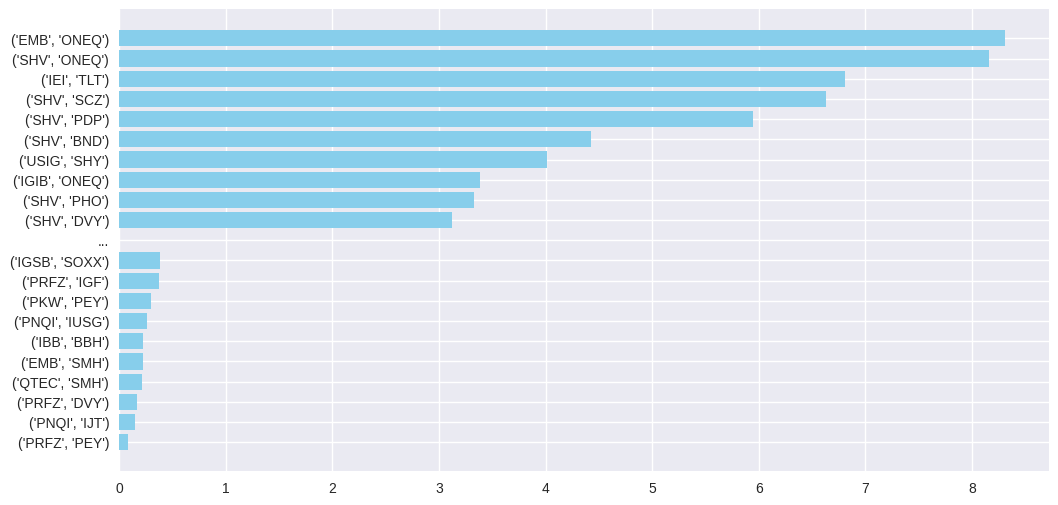

In [5]:
# Step 2: From best cointegrated pairs, find highest validation MSE in Kalman Filters -> best pair
# Useful idea for the dev/validation data: go through all pairs, pick the pair with the highest validation MSE, and use that pair for getting a test MSE.
results = []
for i in tqdm(range(len(pairs_data_filtered)), desc = "Gathering test MSE (and returns) for different pairs.."):
    ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
    pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
    output = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=False, pair_tup_str=f"({ticker_a},{ticker_b})")
    results.append((str(pairs_data_filtered[i][0]), output['val_mse']))

best_scoring_pair_idx = results.index(min(results, key=lambda x: x[1])) # index of the best tuple
results.sort(key=lambda x: x[1])  # sort by MSE
x = 10
top_x = results[:x]
bottom_x = results[-x:]
combined = top_x + [('...', None)] + bottom_x
labels = [item[0] for item in combined]
values = [item[1] for item in combined]
plt.figure(figsize=(12, 6))
bars = plt.barh(labels, [v if v is not None else 0 for v in values], color='skyblue')

In [6]:
# Pick the lowest MSE tickers from that and get the new data
ticker_a, ticker_b = pairs_data_filtered[best_scoring_pair_idx][0][0], pairs_data_filtered[best_scoring_pair_idx][0][1]
pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)

## 3. Kalman Filter Results Test Dataset


In [7]:
# Step 3: Use best pair for Kalman Filters
output_kalman = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=True, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", add_technical_indicators=False)

kalman_val_mse = output_kalman['val_mse']
kalman_test_mse = output_kalman['test_mse']
kalman_yoy_returns_str = f"{output_kalman['yoy_mean'] * 100:.2f}% +- {output_kalman['yoy_std'] * 100:.2f}%"

output_kalman_without_ta = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=True, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", add_technical_indicators=True)
kalman_val_mse_without_ta = output_kalman_without_ta['val_mse']
kalman_test_mse_without_ta = output_kalman_without_ta['test_mse']
kalman_yoy_returns_str_without_ta = f"{output_kalman_without_ta['yoy_mean'] * 100:.2f}% +- {output_kalman_without_ta['yoy_std'] * 100:.2f}%"

Split sizes — train: 2239, dev: 124, test: 125
Saved plot to data/results/data_2008_10_01_2018_10_02_4416cb3b_kalman/data_2008_10_01_2018_10_02_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_10_01_2018_10_02_4416cb3b_kalman/data_2008_10_01_2018_10_02_4416cb3b_groundtruth_comparison.png

Validation MSE: 1.8406249646631174
Test MSE: 1.998517429613437
YOY Returns: 1.32%
YOY Std: +- 0.44%
GT Yoy: 42.99%
Plot filepath parent dir: data/results
Plot filenames: {'yoy_returns': 'data_2008_10_01_2018_10_02_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_10_01_2018_10_02_4416cb3b_groundtruth_comparison.png', 'train_val_loss': None}
  
Split sizes — train: 2239, dev: 124, test: 125
Saved plot to data/results/data_2008_10_01_2018_10_02_4416cb3b_kalman/data_2008_10_01_2018_10_02_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_10_01_2018_10_02_4416cb3b_kalman/data_2008_10_01_2018_10_02_4416cb3b_groundtruth_comparison.png

Validation MSE: 0.

## 4. Transformer Results Test Dataset


In [8]:
# Step 4: Use best pair for Transformers

output_transformer = execute_transformer_workflow(pairs_timeseries_df, verbose=True, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", epochs=20)
transformer_val_mse = output_transformer['val_mse']
transformer_test_mse = output_transformer['test_mse']
transformer_yoy_returns_str = f"{output_transformer['yoy_mean'] * 100:.2f}% +- {output_transformer['yoy_std'] * 100:.2f}%"

output_transformer_without_ta = execute_transformer_workflow(pairs_timeseries_df, verbose=True, add_technical_indicators=False, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", epochs=20)
transformer_val_mse_without_ta = output_transformer_without_ta['val_mse']
transformer_test_mse_without_ta = output_transformer_without_ta['test_mse']
transformer_yoy_returns_str_without_ta = f"{output_transformer_without_ta['yoy_mean'] * 100:.2f}% +- {output_transformer_without_ta['yoy_std'] * 100:.2f}%"

Split sizes — train: 2239, dev: 124, test: 125
Single tensor shape: torch.Size([64, 20, 34])
Epoch 010 | train MSE 0.002908 | val MSE 0.053656
Epoch 020 | train MSE 0.003371 | val MSE 0.046558
Test MSE  : 0.231429
Saved plot to data/results/data_2008_10_01_2018_10_02_4416cb3b_transformer/data_2008_10_01_2018_10_02_4416cb3b_train_val_loss.png
Saved plot to data/results/data_2008_10_01_2018_10_02_4416cb3b_transformer/data_2008_10_01_2018_10_02_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2008_10_01_2018_10_02_4416cb3b_transformer/data_2008_10_01_2018_10_02_4416cb3b_groundtruth_comparison.png

Validation MSE: 0.0465578637444056
Test MSE: 0.23142890632152557
YOY Returns: 21.81%
YOY Std: +- 0.00%
GT Yoy: 30.71%
Plot filepath parent dir: data/results
Plot filenames: {'yoy_returns': 'data_2008_10_01_2018_10_02_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2008_10_01_2018_10_02_4416cb3b_groundtruth_comparison.png', 'train_val_loss': 'data_2008_10_01_2018_10

## 5. Time-Moe Results Test Dataset


In [11]:
# Step 5: Use best pair for Time-MoE.

time_moe_val_mse = None
time_moe_test_mse = None
time_moe_yoy_returns_str = None

## 6. Gather results into table


In [12]:
# Step 6: Get a table for the entire results of this time period using .txt files
start_year = re.search(r"\d{4}", startDateStr).group()
end_year = re.search(r"\d{4}", endDateStr).group()

latex_table = f"""
\\begin{{table}}[h]
\\centering
\\resizebox{{\\textwidth}}{{!}}{{%
\\begin{{tabular}}{{|l|ccc|ccc|}}
\\hline
\\textbf{{Model}} & \\multicolumn{{3}}{{c|}}{{\\textbf{{{start_year}--{end_year}}}}} \\\\
 & \\textbf{{val MSE}} & \\textbf{{test MSE}} & \\textbf{{YoY Returns (std)}} \\\\
\\hline
Kalman Filter & {kalman_val_mse:.4f} & {kalman_test_mse:.4f} & {kalman_yoy_returns_str} \\\\
Kalman Filter$^{{excl}}$ & {kalman_val_mse_without_ta:.4f} & {kalman_test_mse_without_ta:.4f} & {kalman_yoy_returns_str_without_ta} \\\\
Transformer & {transformer_val_mse or 'TBD'} & {transformer_test_mse or 'TBD'} & {transformer_yoy_returns_str or 'TBD'} \\\\
Transformer$^{{excl}}$ & {transformer_val_mse_without_ta or 'TBD'} & {transformer_test_mse_without_ta or 'TBD'} & {transformer_yoy_returns_str_without_ta or 'TBD'} \\\\
Time-MoE$^{{excl}}$ & {time_moe_val_mse or 'TBD'} & {time_moe_test_mse or 'TBD'} & {time_moe_yoy_returns_str or 'TBD'} \\\\
\\hline
\\end{{tabular}}%
}}
\\end{{table}}
"""
print(latex_table)

headers = ["Model", f"{start_year}–{end_year} val MSE", "test MSE", "YoY Returns (std)"]
rows = [
    ["Kalman Filter", f"{kalman_val_mse:.4f}", f"{kalman_test_mse:.4f}", kalman_yoy_returns_str],
    ["Kalman Filter^excl", f"{kalman_val_mse_without_ta:.4f}", f"{kalman_test_mse_without_ta:.4f}", kalman_yoy_returns_str_without_ta],
    ["Transformer", transformer_val_mse or "TBD", transformer_test_mse or "TBD", transformer_yoy_returns_str or "TBD"],
    ["Transformer^excl", transformer_val_mse_without_ta or "TBD", transformer_test_mse_without_ta or "TBD", transformer_yoy_returns_str_without_ta or "TBD"],
    ["Time-MoE^excl", time_moe_val_mse or "TBD", time_moe_test_mse or "TBD", time_moe_yoy_returns_str or "TBD"]
]

print(tabulate(rows, headers=headers, tablefmt="grid"))


\begin{table}[h]
\centering
\resizebox{\textwidth}{!}{%
\begin{tabular}{|l|ccc|ccc|}
\hline
\textbf{Model} & \multicolumn{3}{c|}{\textbf{2008--2018}} \\
 & \textbf{val MSE} & \textbf{test MSE} & \textbf{YoY Returns (std)} \\
\hline
Kalman Filter & 1.8406 & 1.9985 & 1.32% +- 0.44% \\
Kalman Filter$^{excl}$ & 0.0804 & 0.0786 & 39.96% +- 2.72% \\
Transformer & 0.0465578637444056 & 0.23142890632152557 & 21.81% +- 0.00% \\
Transformer$^{excl}$ & 0.020511887394464932 & 0.1023695319890976 & 1.66% +- 0.53% \\
Time-MoE$^{excl}$ & TBD & TBD & TBD \\
\hline
\end{tabular}%
}
\end{table}

+--------------------+----------------------+---------------------+---------------------+
| Model              | 2008–2018 val MSE    | test MSE            | YoY Returns (std)   |
+====================+======================+=====================+=====================+
| Kalman Filter      | 1.8406               | 1.9985              | 1.32% +- 0.44%      |
+--------------------+----------------------+-----------

## 7. Repeat for 5 other time periods


In [20]:
# Step 7: Make this into a function that gathers table at once, and repeat for all other time periods
def gather_results_timeperiod(startDateStr, endDateStr, train_frac, dev_frac):
  verbose = False

  instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
  data = gather_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
  data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
  data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

  scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
  pairs_data = {key:value[1]  for (key, value) in pairs.items()}
  pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
  pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
  # Extract the most highly cointegrated pairs

  results = []
  for i in tqdm(range(len(pairs_data_filtered)), desc = "Gathering test MSE (and returns) for different pairs.."):
      ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
      pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
      output = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=verbose, pair_tup_str=f"({ticker_a},{ticker_b})")
      results.append((str(pairs_data_filtered[i][0]), output['val_mse']))

  best_scoring_pair_idx = results.index(min(results, key=lambda x: x[1])) # index of the best tuple

  ticker_a, ticker_b = pairs_data_filtered[best_scoring_pair_idx][0][0], pairs_data_filtered[best_scoring_pair_idx][0][1]
  pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)

  # Step 3: Use best pair for Kalman Filters
  output_kalman = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=verbose, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", add_technical_indicators=False)

  kalman_val_mse = output_kalman['val_mse']
  kalman_test_mse = output_kalman['test_mse']
  kalman_yoy_returns_str = f"{output_kalman['yoy_mean'] * 100:.2f}% +- {output_kalman['yoy_std'] * 100:.2f}%"

  output_kalman_without_ta = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=verbose, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", add_technical_indicators=True)
  kalman_val_mse_without_ta = output_kalman_without_ta['val_mse']
  kalman_test_mse_without_ta = output_kalman_without_ta['test_mse']
  kalman_yoy_returns_str_without_ta = f"{output_kalman_without_ta['yoy_mean'] * 100:.2f}% +- {output_kalman_without_ta['yoy_std'] * 100:.2f}%"

  # Step 4: Use best pair for Transformers

  output_transformer = execute_transformer_workflow(pairs_timeseries_df, verbose=verbose, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", epochs=20)
  transformer_val_mse = output_transformer['val_mse']
  transformer_test_mse = output_transformer['test_mse']
  transformer_yoy_returns_str = f"{output_transformer['yoy_mean'] * 100:.2f}% +- {output_transformer['yoy_std'] * 100:.2f}%"

  output_transformer_without_ta = execute_transformer_workflow(pairs_timeseries_df, verbose=verbose, add_technical_indicators=False, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", epochs=20)
  transformer_val_mse_without_ta = output_transformer_without_ta['val_mse']
  transformer_test_mse_without_ta = output_transformer_without_ta['test_mse']
  transformer_yoy_returns_str_without_ta = f"{output_transformer_without_ta['yoy_mean'] * 100:.2f}% +- {output_transformer_without_ta['yoy_std'] * 100:.2f}%"

  # Step 5: Use best pair for Time-MoE.

  time_moe_val_mse = None
  time_moe_test_mse = None
  time_moe_yoy_returns_str = None

  # Step 6: Get a table for the entire results of this time period using .txt files
  start_year = re.search(r"\d{4}", startDateStr).group()
  end_year = re.search(r"\d{4}", endDateStr).group()

  latex_table = f"""
  \\begin{{table}}[h]
  \\centering
  \\resizebox{{\\textwidth}}{{!}}{{%
  \\begin{{tabular}}{{|l|ccc|ccc|}}
  \\hline
  \\textbf{{Model}} & \\multicolumn{{3}}{{c|}}{{\\textbf{{{start_year}--{end_year}}}}} \\\\
  & \\textbf{{val MSE}} & \\textbf{{test MSE}} & \\textbf{{YoY Returns (std)}} \\\\
  \\hline
  Kalman Filter & {kalman_val_mse:.4f} & {kalman_test_mse:.4f} & {kalman_yoy_returns_str} \\\\
  Kalman Filter$^{{excl}}$ & {kalman_val_mse_without_ta:.4f} & {kalman_test_mse_without_ta:.4f} & {kalman_yoy_returns_str_without_ta} \\\\
  Transformer & {transformer_val_mse or 'TBD'} & {transformer_test_mse or 'TBD'} & {transformer_yoy_returns_str or 'TBD'} \\\\
  Transformer$^{{excl}}$ & {transformer_val_mse_without_ta or 'TBD'} & {transformer_test_mse_without_ta or 'TBD'} & {transformer_yoy_returns_str_without_ta or 'TBD'} \\\\
  Time-MoE$^{{excl}}$ & {time_moe_val_mse or 'TBD'} & {time_moe_test_mse or 'TBD'} & {time_moe_yoy_returns_str or 'TBD'} \\\\
  \\hline
  \\end{{tabular}}%
  }}
  \\end{{table}}
  """
  print(latex_table)

  headers = ["Model", f"{start_year}–{end_year} val MSE", "test MSE", "YoY Returns (std)"]
  rows = [
      ["Kalman Filter", f"{kalman_val_mse:.4f}", f"{kalman_test_mse:.4f}", kalman_yoy_returns_str],
      ["Kalman Filter^excl", f"{kalman_val_mse_without_ta:.4f}", f"{kalman_test_mse_without_ta:.4f}", kalman_yoy_returns_str_without_ta],
      ["Transformer", transformer_val_mse or "TBD", transformer_test_mse or "TBD", transformer_yoy_returns_str or "TBD"],
      ["Transformer^excl", transformer_val_mse_without_ta or "TBD", transformer_test_mse_without_ta or "TBD", transformer_yoy_returns_str_without_ta or "TBD"],
      ["Time-MoE^excl", time_moe_val_mse or "TBD", time_moe_test_mse or "TBD", time_moe_yoy_returns_str or "TBD"]
  ]

  print(tabulate(rows, headers=headers, tablefmt="grid"))

  # save both tables to total_results
  total_results_dir = "data/results/total_results"
  os.makedirs(total_results_dir, exist_ok=True)

  with open(f"{total_results_dir}/table_{start_year}_{end_year}.tex", "w") as f:
      f.write(latex_table)

  with open(f"{total_results_dir}/table_{start_year}_{end_year}.txt", "w") as f:
      f.write(tabulate(rows, headers=headers, tablefmt="grid"))

def _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest, verbose=False):
  """
  For certain periods, we want a specific testing period, and must therefore calculate the train/dev split based on that.
  """
  # convert all 4 dates to datetime
  startDateStr = datetime.strptime(startDateStr, '%Y-%m-%d')
  endDateStr = datetime.strptime(endDateStr, '%Y-%m-%d')
  startDateStrTest = datetime.strptime(startDateStrTest, '%Y-%m-%d')
  endDateStrTest = datetime.strptime(endDateStrTest, '%Y-%m-%d')

  total_days = (endDateStr - startDateStr).days
  test_days = (endDateStrTest - startDateStrTest).days
  train_days = total_days - 2 * test_days

  train_frac = train_days / total_days
  test_frac = test_days / total_days
  dev_frac = test_frac

  if verbose:
    print(f"train_frac: {train_frac}")
    print(f"dev_frac: {dev_frac}")
    print(f"test_frac: {test_frac}")

  return train_frac, dev_frac

## PERIOD 1
startDateStr1 = '2010-10-01'
endDateStr1 = '2024-10-02'
train_frac1 = 0.90
dev_frac1 = 0.05

## PERIOD 2
startDateStr2 = '2008-10-01'
endDateStr2 = '2018-10-02'
train_frac2 = 0.90
dev_frac2 = 0.05

## PERIOD 3
startDateStr3 = '2007-01-01'
endDateStr3 = '2022-12-31'
# wanted test year: test 2022/01-2022/12
startDateStrTest3 = '2022-01-01'
endDateStrTest3 = '2022-12-31'
train_frac3, dev_frac3 = _get_train_dev_frac(startDateStr3, endDateStr3, startDateStrTest3, endDateStrTest3)

## PERIOD 4
startDateStr4 = '2007-01-01'
endDateStr4 = '2024-12-31'
# test 2024/01-2024/12
startDateStrTest4 = '2024-01-01'
endDateStrTest4 = '2024-12-31'
train_frac4, dev_frac4 = _get_train_dev_frac(startDateStr4, endDateStr4, startDateStrTest4, endDateStrTest4)

## PERIOD 5
startDateStr5 = '2007-01-01'
endDateStr5 = '2016-12-31'
# test 2014/07-2016
startDateStrTest5 = '2014-07-01'
endDateStrTest5 = '2016-12-31'
train_frac5, dev_frac5 = _get_train_dev_frac(startDateStr5, endDateStr5, startDateStrTest5, endDateStrTest5)

## PERIOD 6
startDateStr6 = '2007-01-01'
endDateStr6 = '2021-12-31'
# test 2020/01-2021/12
startDateStrTest6 = '2020-01-01'
endDateStrTest6 = '2021-12-31'
train_frac6, dev_frac6 = _get_train_dev_frac(startDateStr6, endDateStr6, startDateStrTest6, endDateStrTest6)

all_inputs = [
    (startDateStr1, endDateStr1, train_frac1, dev_frac1),
    (startDateStr2, endDateStr2, train_frac2, dev_frac2),
    (startDateStr3, endDateStr3, train_frac3, dev_frac3),
    (startDateStr4, endDateStr4, train_frac4, dev_frac4),
    (startDateStr5, endDateStr5, train_frac5, dev_frac5),
    (startDateStr6, endDateStr6, train_frac6, dev_frac6)
]

for inputs in all_inputs:
  gather_results_timeperiod(*inputs)

Processing pairs: 100%|██████████| 1711/1711 [05:48<00:00,  4.91it/s]


Completed 1711 pairs


Gathering test MSE (and returns) for different pairs..:   0%|          | 0/134 [00:00<?, ?it/s]

/content/bsc-thesis/src/backtesting/utils.py:53: RuntimeWarning: invalid value encountered in scalar power
  return ((mean_returns[-1] / mean_returns[0])**(365 / len(mean_returns)) - 1), ((std_returns[-1] / mean_returns[0]) * np.sqrt(365 / len(mean_returns)))
/content/bsc-thesis/src/backtesting/utils.py:53: RuntimeWarning: invalid value encountered in scalar power
  return ((mean_returns[-1] / mean_returns[0])**(365 / len(mean_returns)) - 1), ((std_returns[-1] / mean_returns[0]) * np.sqrt(365 / len(mean_returns)))
/content/bsc-thesis/src/backtesting/utils.py:53: RuntimeWarning: invalid value encountered in scalar power
  return ((mean_returns[-1] / mean_returns[0])**(365 / len(mean_returns)) - 1), ((std_returns[-1] / mean_returns[0]) * np.sqrt(365 / len(mean_returns)))
/content/bsc-thesis/src/backtesting/utils.py:53: RuntimeWarning: invalid value encountered in scalar power
  return ((mean_returns[-1] / mean_returns[0])**(365 / len(mean_returns)) - 1), ((std_returns[-1] / mean_returns[

Epoch 010 | train MSE 0.004326 | val MSE 0.028002
Epoch 020 | train MSE 0.003765 | val MSE 0.021674
Test MSE  : 0.263264
Epoch 010 | train MSE 0.003656 | val MSE 0.034567
Epoch 020 | train MSE 0.003598 | val MSE 0.042904
Test MSE  : 0.281672

  \begin{table}[h]
  \centering
  \resizebox{\textwidth}{!}{%
  \begin{tabular}{|l|ccc|ccc|}
  \hline
  \textbf{Model} & \multicolumn{3}{c|}{\textbf{2010--2024}} \\
  & \textbf{val MSE} & \textbf{test MSE} & \textbf{YoY Returns (std)} \\
  \hline
  Kalman Filter & 1.9515 & 2.6148 & -2.04% +- 0.57% \\
  Kalman Filter$^{excl}$ & 0.0866 & 0.4921 & -17.54% +- 3.87% \\
  Transformer & 0.02167395768421037 & 0.2632642686367035 & -24.99% +- 1.62% \\
  Transformer$^{excl}$ & 0.04290370207715344 & 0.2816718816757202 & 13.18% +- 3.48% \\
  Time-MoE$^{excl}$ & TBD & TBD & TBD \\
  \hline
  \end{tabular}%
  }
  \end{table}
  
+--------------------+---------------------+--------------------+---------------------+
| Model              | 2010–2024 val MSE   | tes

Processing pairs: 100%|██████████| 820/820 [01:36<00:00,  8.45it/s]

Completed 820 pairs


Gathering test MSE (and returns) for different pairs..:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 010 | train MSE 0.003468 | val MSE 0.051965
Epoch 020 | train MSE 0.003004 | val MSE 0.047013
Test MSE  : 0.281249
Epoch 010 | train MSE 0.004637 | val MSE 0.026361
Epoch 020 | train MSE 0.004018 | val MSE 0.022076
Test MSE  : 0.099777

  \begin{table}[h]
  \centering
  \resizebox{\textwidth}{!}{%
  \begin{tabular}{|l|ccc|ccc|}
  \hline
  \textbf{Model} & \multicolumn{3}{c|}{\textbf{2008--2018}} \\
  & \textbf{val MSE} & \textbf{test MSE} & \textbf{YoY Returns (std)} \\
  \hline
  Kalman Filter & 1.8406 & 1.9985 & 1.32% +- 0.44% \\
  Kalman Filter$^{excl}$ & 0.0804 & 0.0786 & 39.96% +- 2.72% \\
  Transformer & 0.04701278473322208 & 0.28124889731407166 & 21.78% +- 0.00% \\
  Transformer$^{excl}$ & 0.02207558315533858 & 0.09977655112743378 & 1.98% +- 0.77% \\
  Time-MoE$^{excl}$ & TBD & TBD & TBD \\
  \hline
  \end{tabular}%
  }
  \end{table}
  
+--------------------+---------------------+---------------------+---------------------+
| Model              | 2008–2018 val MSE   | test

Processing pairs: 100%|██████████| 253/253 [01:04<00:00,  3.94it/s]

Completed 253 pairs


Gathering test MSE (and returns) for different pairs..:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | train MSE 0.002636 | val MSE 0.035838
Epoch 020 | train MSE 0.002502 | val MSE 0.034631
Test MSE  : 2.403886
Epoch 010 | train MSE 0.003417 | val MSE 0.015008
Epoch 020 | train MSE 0.003364 | val MSE 0.014449
Test MSE  : 0.829216

  \begin{table}[h]
  \centering
  \resizebox{\textwidth}{!}{%
  \begin{tabular}{|l|ccc|ccc|}
  \hline
  \textbf{Model} & \multicolumn{3}{c|}{\textbf{2007--2022}} \\
  & \textbf{val MSE} & \textbf{test MSE} & \textbf{YoY Returns (std)} \\
  \hline
  Kalman Filter & 2.1434 & 1.8008 & 0.39% +- 0.71% \\
  Kalman Filter$^{excl}$ & 0.1971 & 0.1593 & -36.03% +- 3.56% \\
  Transformer & 0.03463116381837669 & 2.403885841369629 & -32.80% +- 13.01% \\
  Transformer$^{excl}$ & 0.014448578911703392 & 0.8292160630226135 & 1.81% +- 0.62% \\
  Time-MoE$^{excl}$ & TBD & TBD & TBD \\
  \hline
  \end{tabular}%
  }
  \end{table}
  
+--------------------+----------------------+--------------------+---------------------+
| Model              | 2007–2022 val MSE    | te

Processing pairs: 100%|██████████| 253/253 [01:15<00:00,  3.33it/s]

Completed 253 pairs


Gathering test MSE (and returns) for different pairs..:   0%|          | 0/8 [00:00<?, ?it/s]

/content/bsc-thesis/src/backtesting/utils.py:53: RuntimeWarning: invalid value encountered in scalar power
  return ((mean_returns[-1] / mean_returns[0])**(365 / len(mean_returns)) - 1), ((std_returns[-1] / mean_returns[0]) * np.sqrt(365 / len(mean_returns)))
/content/bsc-thesis/src/models/statistical_models.py:276: RuntimeWarning: invalid value encountered in power
  gt_yoy = ((gt_returns[-1] / gt_returns[0])**(365 / len(gt_returns)) - 1)[0]


Epoch 010 | train MSE 0.002100 | val MSE 0.008727
Epoch 020 | train MSE 0.001602 | val MSE 0.008481
Test MSE  : 15.806703
Epoch 010 | train MSE 0.007009 | val MSE 0.010361
Epoch 020 | train MSE 0.005573 | val MSE 0.008833
Test MSE  : 0.163383

  \begin{table}[h]
  \centering
  \resizebox{\textwidth}{!}{%
  \begin{tabular}{|l|ccc|ccc|}
  \hline
  \textbf{Model} & \multicolumn{3}{c|}{\textbf{2007--2024}} \\
  & \textbf{val MSE} & \textbf{test MSE} & \textbf{YoY Returns (std)} \\
  \hline
  Kalman Filter & 1.5965 & 2.4336 & 2.34% +- 1.14% \\
  Kalman Filter$^{excl}$ & 0.2778 & 0.3868 & -57.36% +- 56.15% \\
  Transformer & 0.008480556382268084 & 15.806702613830566 & -71.45% +- 42.68% \\
  Transformer$^{excl}$ & 0.008832824179062657 & 0.163382887840271 & -8.98% +- 2.10% \\
  Time-MoE$^{excl}$ & TBD & TBD & TBD \\
  \hline
  \end{tabular}%
  }
  \end{table}
  
+--------------------+----------------------+--------------------+---------------------+
| Model              | 2007–2024 val MSE    

Processing pairs: 100%|██████████| 210/210 [00:25<00:00,  8.18it/s]

Completed 210 pairs


Gathering test MSE (and returns) for different pairs..:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 010 | train MSE 0.005638 | val MSE 0.042090
Epoch 020 | train MSE 0.004298 | val MSE 0.028311
Test MSE  : 0.874776
Epoch 010 | train MSE 0.005316 | val MSE 0.033095
Epoch 020 | train MSE 0.004585 | val MSE 0.036656
Test MSE  : 0.767765

  \begin{table}[h]
  \centering
  \resizebox{\textwidth}{!}{%
  \begin{tabular}{|l|ccc|ccc|}
  \hline
  \textbf{Model} & \multicolumn{3}{c|}{\textbf{2007--2016}} \\
  & \textbf{val MSE} & \textbf{test MSE} & \textbf{YoY Returns (std)} \\
  \hline
  Kalman Filter & 1.5061 & 1.6680 & -1.88% +- 0.69% \\
  Kalman Filter$^{excl}$ & 0.3139 & 0.5951 & -66.34% +- 12.28% \\
  Transformer & 0.028310606256127357 & 0.874776303768158 & -54.20% +- 2.58% \\
  Transformer$^{excl}$ & 0.03665554691822483 & 0.7677651643753052 & 9.34% +- 0.22% \\
  Time-MoE$^{excl}$ & TBD & TBD & TBD \\
  \hline
  \end{tabular}%
  }
  \end{table}
  
+--------------------+----------------------+--------------------+---------------------+
| Model              | 2007–2016 val MSE    | t

Processing pairs: 100%|██████████| 253/253 [00:56<00:00,  4.46it/s]

Completed 253 pairs


Gathering test MSE (and returns) for different pairs..:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 010 | train MSE 0.002799 | val MSE 0.007627
Epoch 020 | train MSE 0.002458 | val MSE 0.006706
Test MSE  : 40.075417


/content/bsc-thesis/src/backtesting/utils.py:53: RuntimeWarning: invalid value encountered in scalar power
  return ((mean_returns[-1] / mean_returns[0])**(365 / len(mean_returns)) - 1), ((std_returns[-1] / mean_returns[0]) * np.sqrt(365 / len(mean_returns)))


Epoch 010 | train MSE 0.004232 | val MSE 0.018332
Epoch 020 | train MSE 0.003306 | val MSE 0.010354
Test MSE  : 0.211514

  \begin{table}[h]
  \centering
  \resizebox{\textwidth}{!}{%
  \begin{tabular}{|l|ccc|ccc|}
  \hline
  \textbf{Model} & \multicolumn{3}{c|}{\textbf{2007--2021}} \\
  & \textbf{val MSE} & \textbf{test MSE} & \textbf{YoY Returns (std)} \\
  \hline
  Kalman Filter & 1.8843 & 3.1113 & -1.93% +- 1.39% \\
  Kalman Filter$^{excl}$ & 0.2412 & 0.2696 & -100.00% +- 0.31% \\
  Transformer & 0.006706420549687868 & 40.075416564941406 & nan% +- 287.00% \\
  Transformer$^{excl}$ & 0.01035383970526878 & 0.21151356399059296 & 0.97% +- 0.40% \\
  Time-MoE$^{excl}$ & TBD & TBD & TBD \\
  \hline
  \end{tabular}%
  }
  \end{table}
  
+--------------------+----------------------+---------------------+---------------------+
| Model              | 2007–2021 val MSE    | test MSE            | YoY Returns (std)   |
+====================+======================+=====================+=========